In [58]:
import math
import os
import random

import albumentations as A
import albumentations_experimental as AE
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torchvision
from PIL import Image
from albumentations.pytorch import ToTensorV2
from pytorch_lightning import LightningModule
from pytorch_lightning.callbacks import Callback, ModelCheckpoint
from sklearn.metrics import confusion_matrix
from torch.nn import functional as F
from torch.nn.modules.loss import _WeightedLoss
from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.models import resnet50, ResNet50_Weights

from dataset import ImagesDataset, get_learn_data
from topoloss import TopoLoss
from models import AutoEncoder, AutoEncoderRes
from train import fit
from predict import make_prediction

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
noise_transformations = A.Compose([
    A.CoarseDropout(max_holes=2, max_height=2, max_width=20, fill_value=0),
    A.CoarseDropout(max_holes=2, max_height=20, max_width=2, fill_value=0)
])

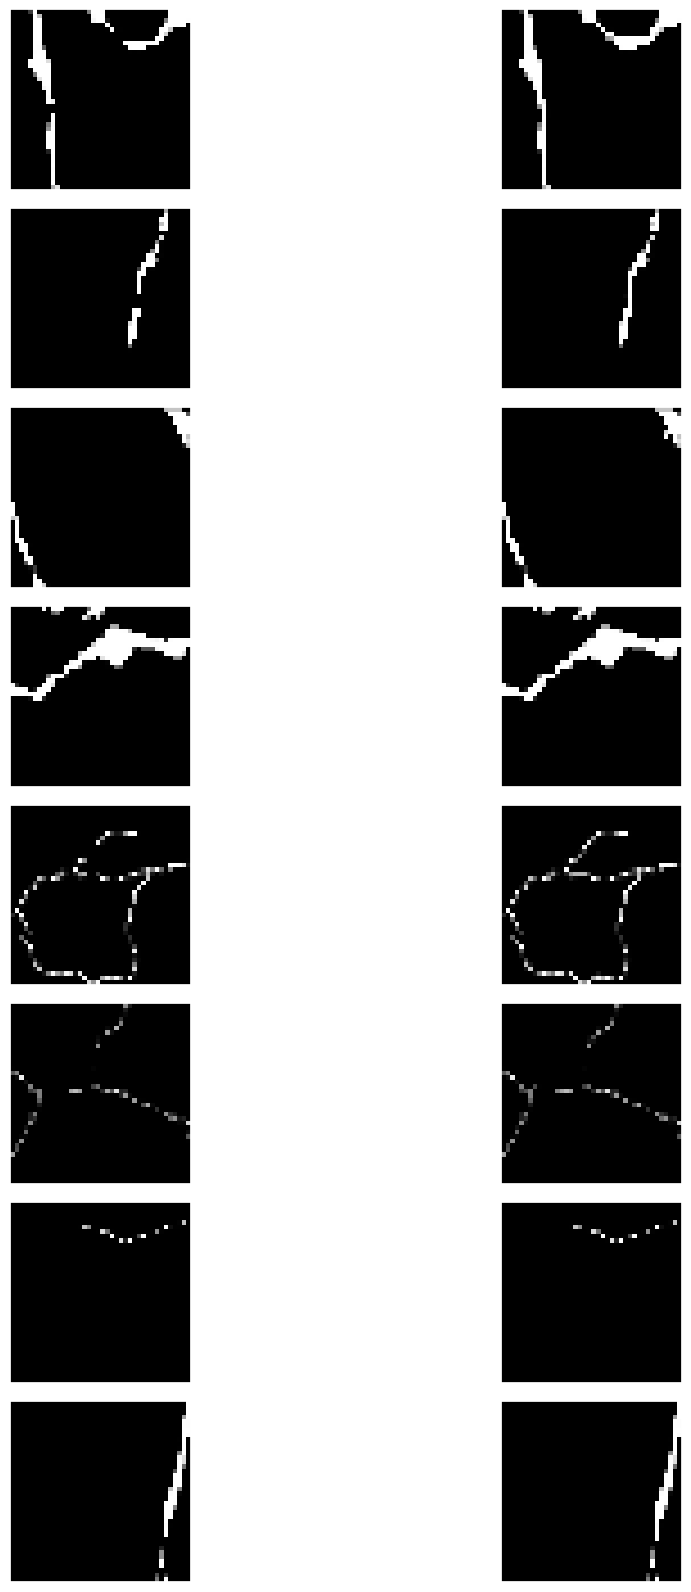

In [53]:
torch.manual_seed(0)
np.random.seed(0)

train_loader, val_loader, test_loader = get_learn_data("data/Final_Dataset/Masks", noise_transformations=noise_transformations,
                                                 patch_mode="resize", patch_size=(40, 40), img_size=(400, 400), batch_size=32)

noised_images, gt_images, img_names, patch_nums = next(iter(train_loader))

fig = plt.figure(figsize=(10, 32))
for idx in np.arange(8):
    # noised input
    ax1 = fig.add_subplot(16, 2, 2 * idx + 1, xticks=[], yticks=[])
    ax1.imshow(np.squeeze(noised_images[idx]).moveaxis(0, 2))

    # gt image
    ax3 = fig.add_subplot(16, 2, 2 * idx + 2, xticks=[], yticks=[])
    ax3.imshow(np.squeeze(gt_images[idx]).moveaxis(0, 2))

    fig.tight_layout()
plt.show()

Эксперимент с bceloss на малом числе эпох

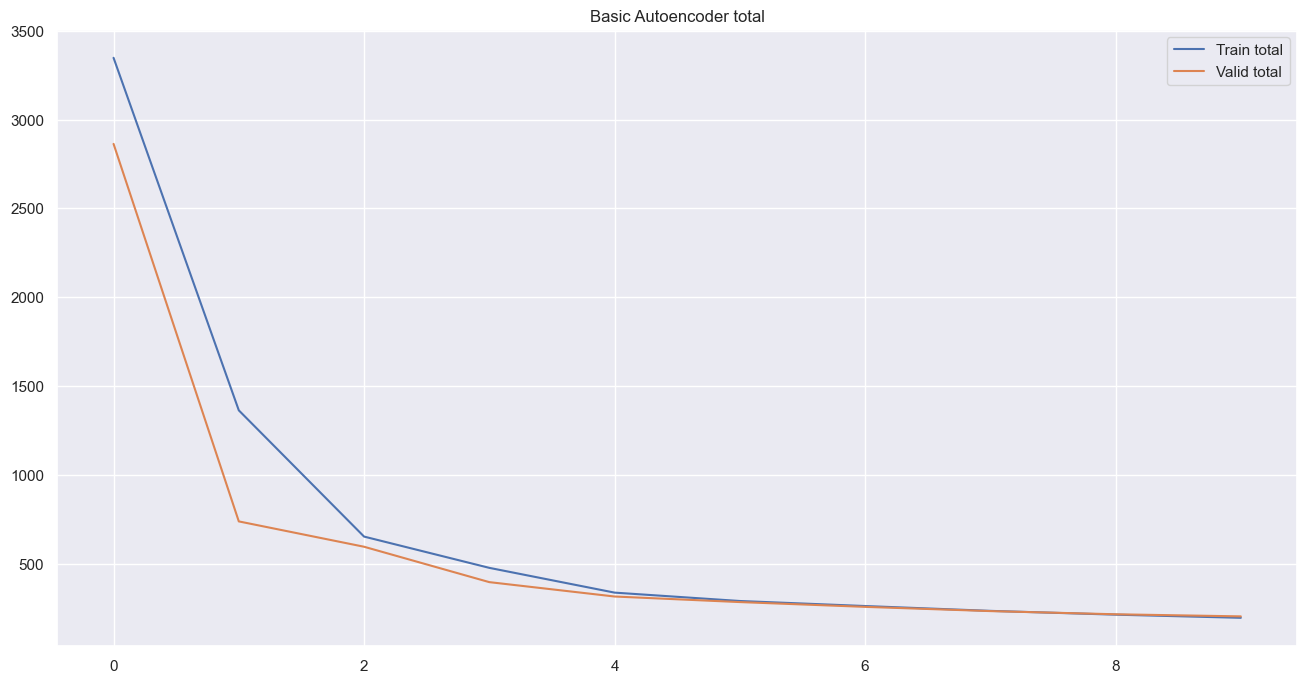

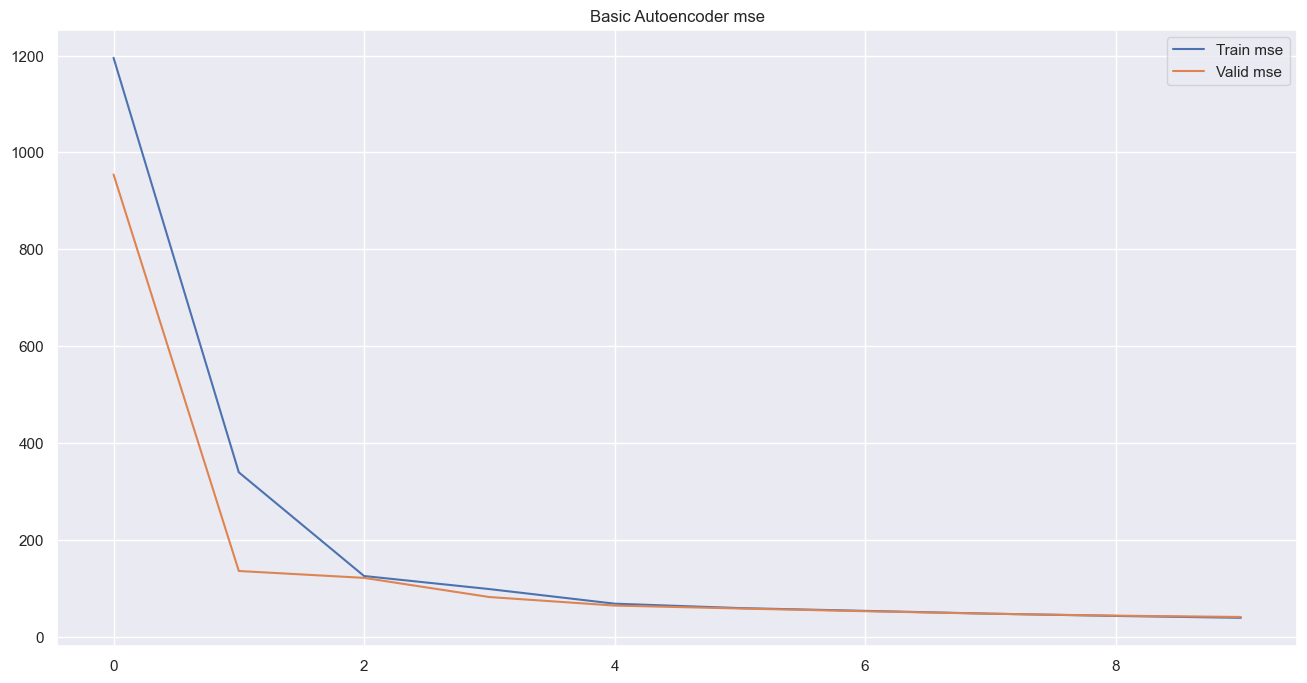

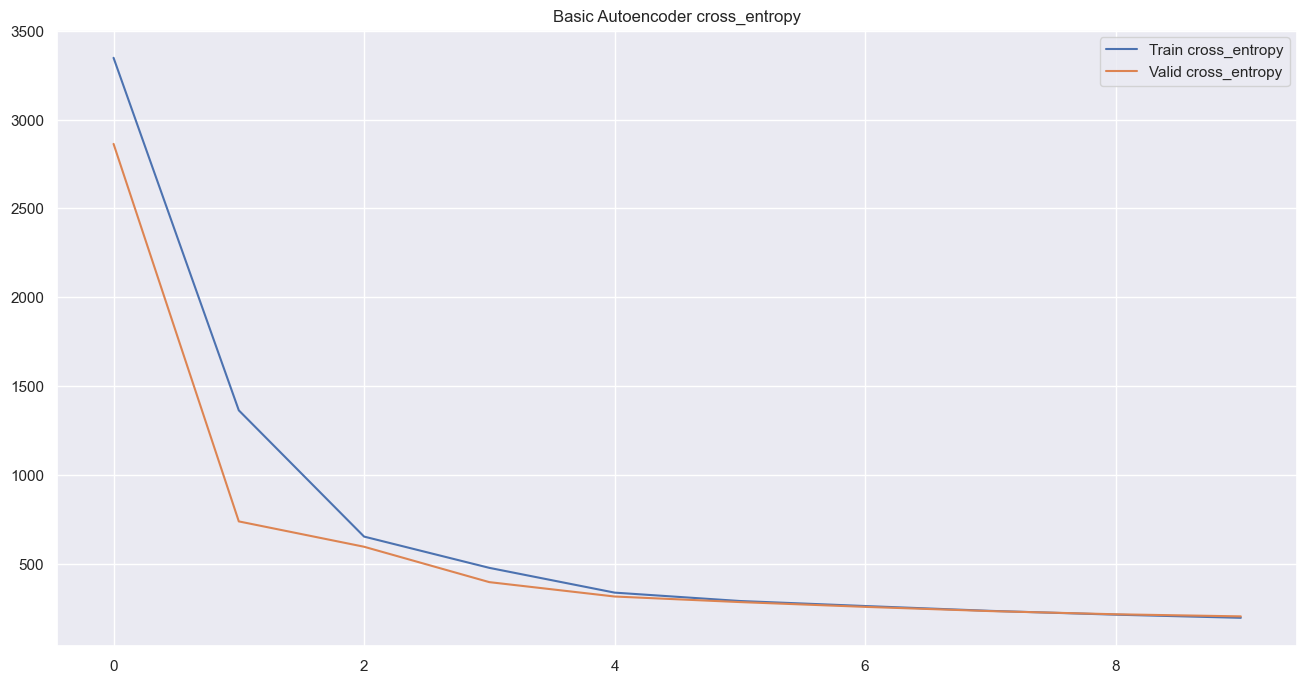

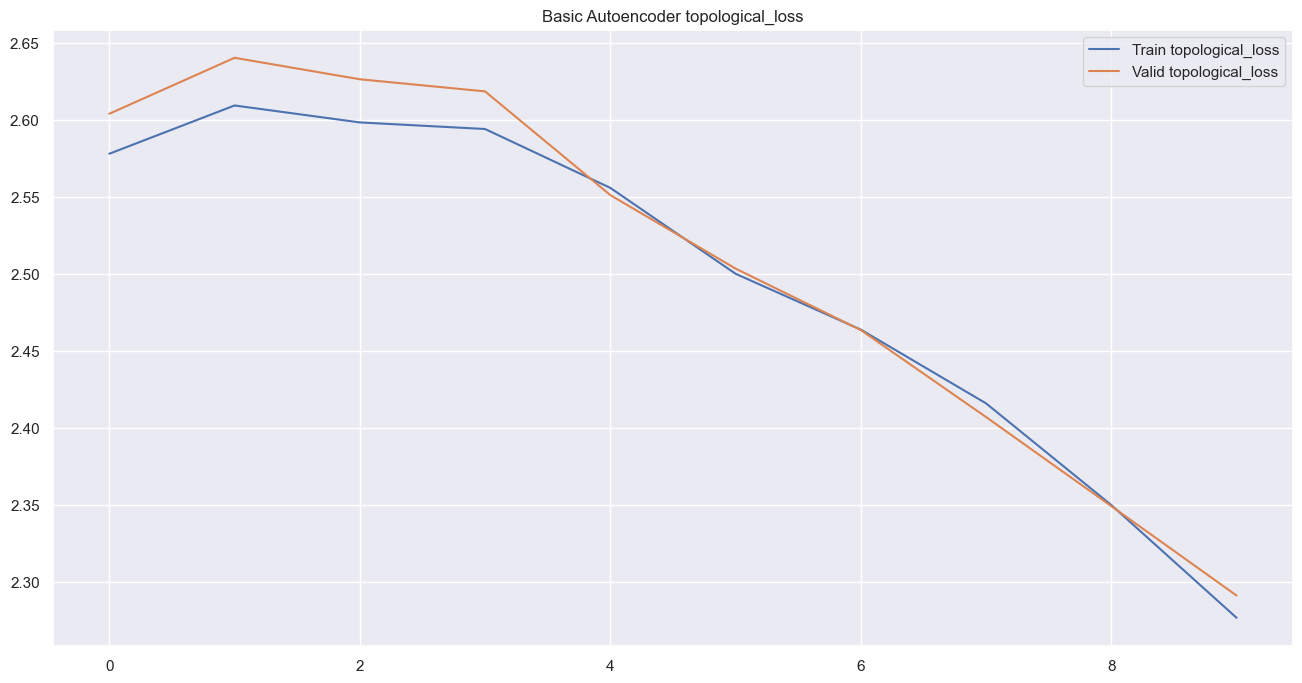

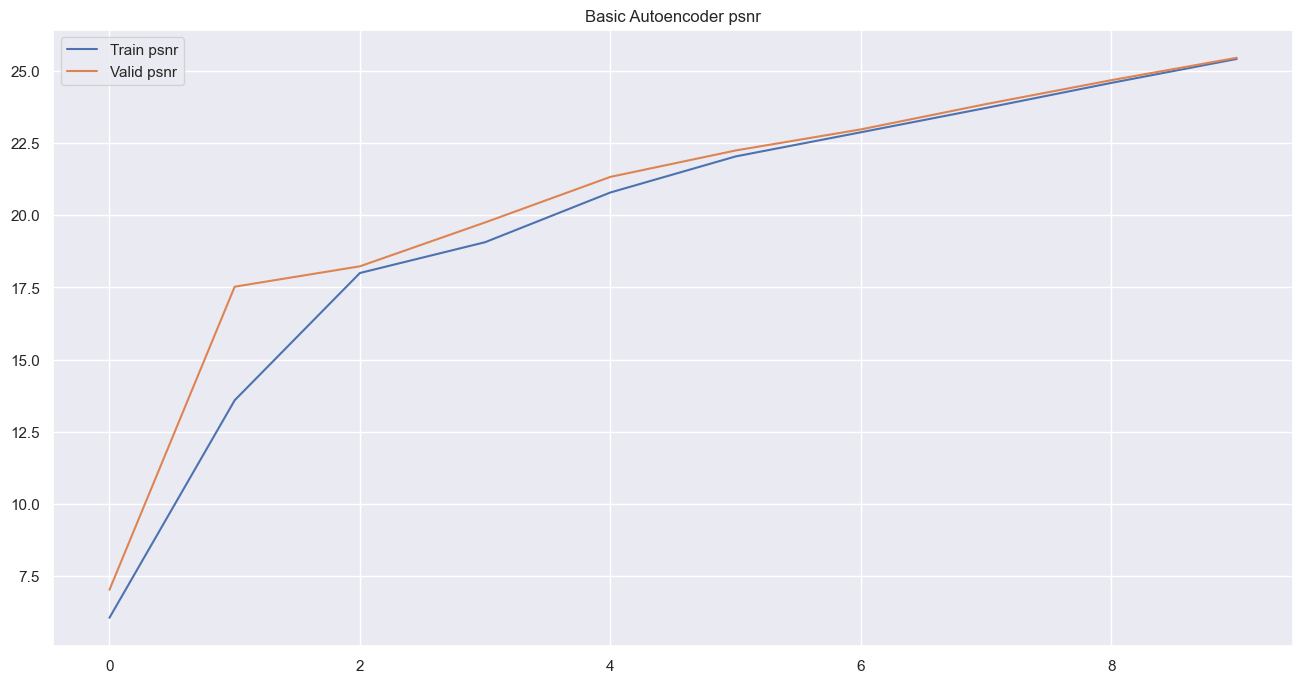

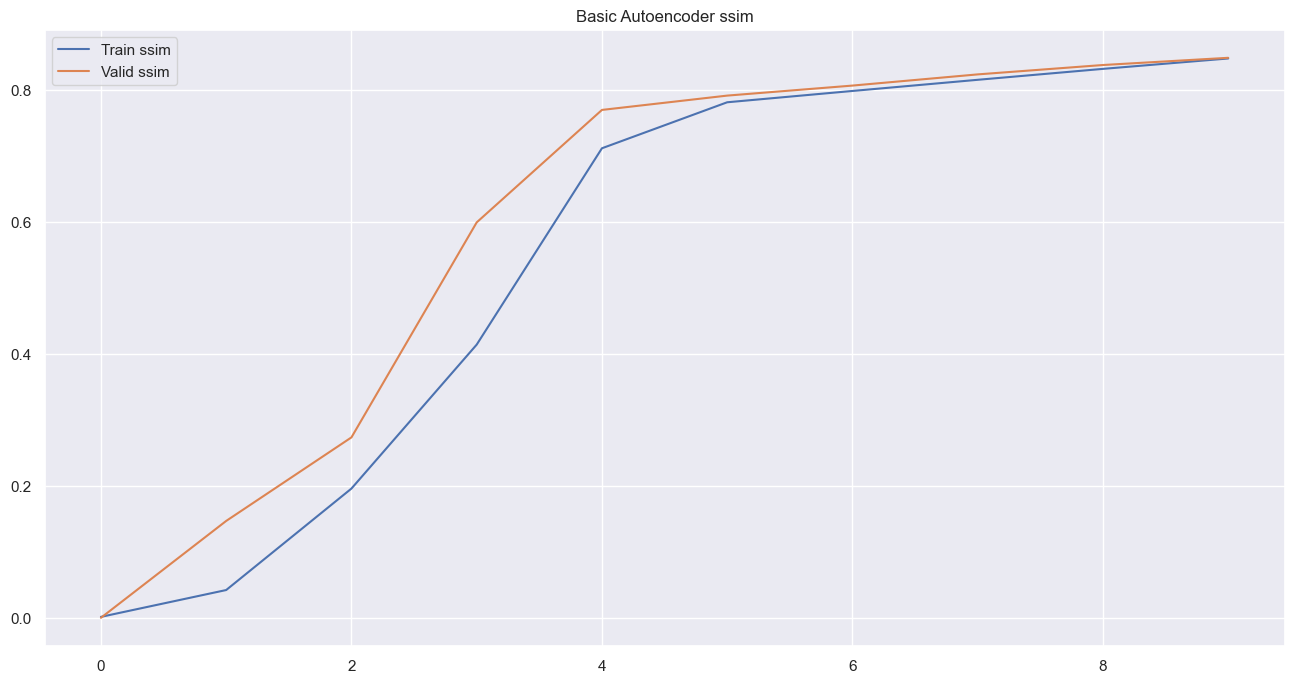

Epoch 9
 train loss: {'total': 195.90841971302484, 'mse': 39.618021273499984, 'cross_entropy': 195.90841971302484, 'topological_loss': 2.2765654545824674}, train metrics: {'psnr': 25.423881268614277, 'ssim': 0.8484443567375436}
 val loss: {'total': 203.95299396243706, 'mse': 41.34661055289173, 'cross_entropy': 203.95299396243706, 'topological_loss': 2.291019602409471}, val metrics: {'psnr': 25.463843973891993, 'ssim': 0.8494659769591562}



([{'total': 3347.192146771327,
   'mse': 1195.2989180867705,
   'cross_entropy': 3347.192146771327,
   'topological_loss': 2.5778940108150104},
  {'total': 1363.3007089334642,
   'mse': 339.8673306144244,
   'cross_entropy': 1363.3007089334642,
   'topological_loss': 2.6092446822125765},
  {'total': 652.9623757312648,
   'mse': 125.85700721198349,
   'cross_entropy': 652.9623757312648,
   'topological_loss': 2.5982411054638326},
  {'total': 476.97779260427467,
   'mse': 98.90747128165728,
   'cross_entropy': 476.97779260427467,
   'topological_loss': 2.5939575190792716},
  {'total': 337.63824535207164,
   'mse': 68.79471206665039,
   'cross_entropy': 337.63824535207164,
   'topological_loss': 2.555736010673487},
  {'total': 290.4895810674152,
   'mse': 59.6734455705254,
   'cross_entropy': 290.4895810674152,
   'topological_loss': 2.499971875647233},
  {'total': 262.17636976196866,
   'mse': 53.949473448839235,
   'cross_entropy': 262.17636976196866,
   'topological_loss': 2.4636926345

In [54]:
torch.manual_seed(0)
np.random.seed(0)

train_loader, val_loader, test_loader = get_learn_data("data/Final_Dataset/Masks", noise_transformations=noise_transformations,
                                                       patch_mode="resize", patch_size=(40, 40), img_size=(400, 400), batch_size=32)

net = AutoEncoder()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)
loss_fn = nn.BCELoss(reduction="sum")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

fit(net, optimizer, 10, train_loader, val_loader, loss_fn,
    device, title="Basic Autoencoder", save_checkpoints=False, path="",
    log_wandb=False)

In [55]:
results = make_prediction(net, test_loader, device)

100%|██████████| 53/53 [00:06<00:00,  7.88it/s]


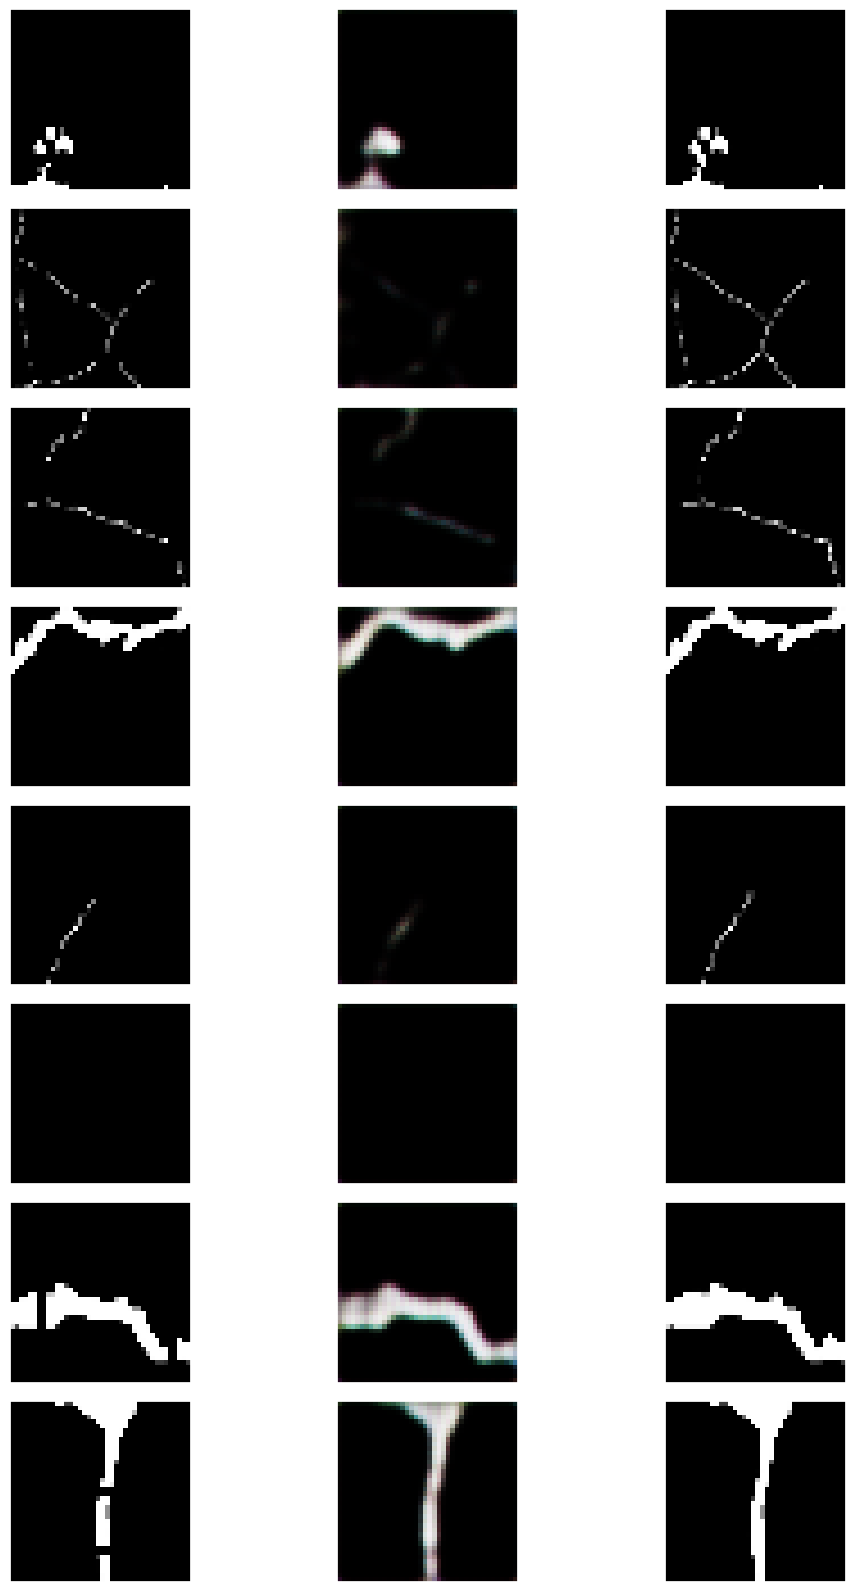

In [57]:
noised_images, gt_images, img_names, patch_nums = next(iter(test_loader))

fig = plt.figure(figsize=(10, 32))
start = 24
for idx in np.arange(start, start + 8):
    # noised input
    ax1 = fig.add_subplot(16, 3, 3 * (idx - start) + 1, xticks=[], yticks=[])
    ax1.imshow(np.squeeze(noised_images[idx]).moveaxis(0, 2))

    # model output
    ax2 = fig.add_subplot(16, 3, 3 * (idx - start) + 2, xticks=[], yticks=[])
    ax2.imshow(np.squeeze(results[img_names[idx]]).transpose(1, 2, 0))

    # gt image
    ax3 = fig.add_subplot(16, 3, 3 * (idx - start) + 3, xticks=[], yticks=[])
    ax3.imshow(np.squeeze(gt_images[idx]).moveaxis(0, 2))

    fig.tight_layout()
plt.show()

Эксперимент с bceloss

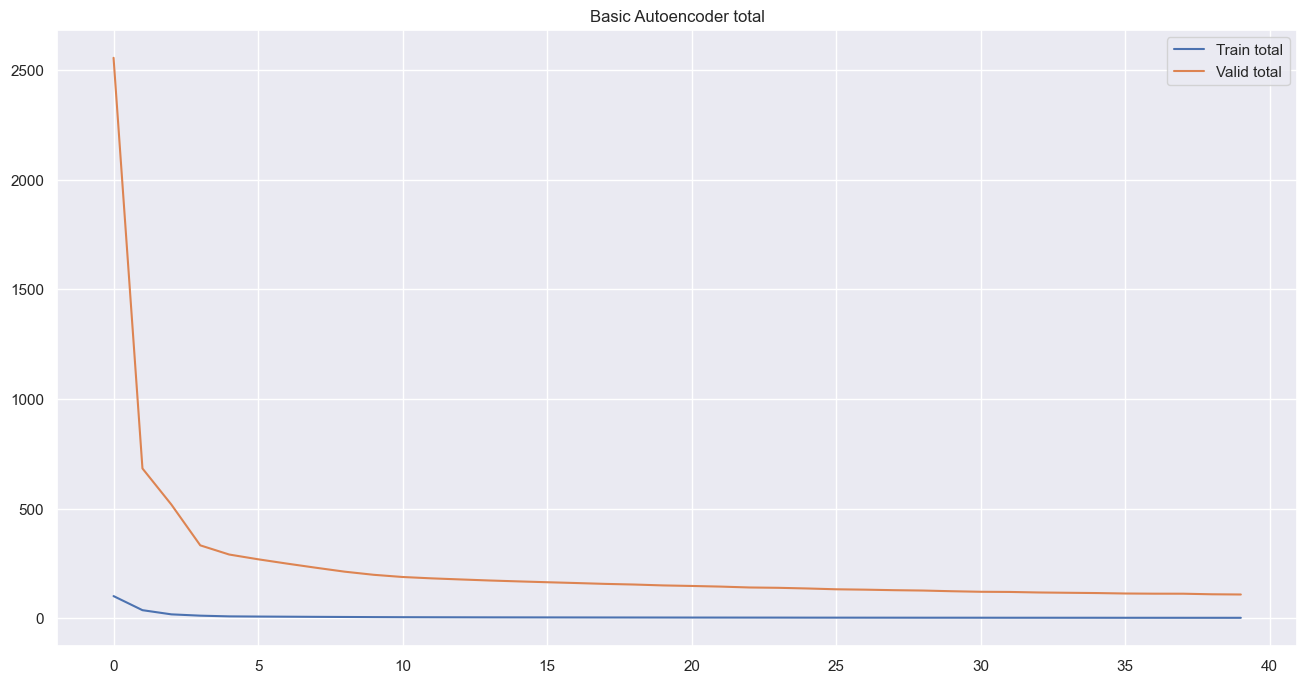

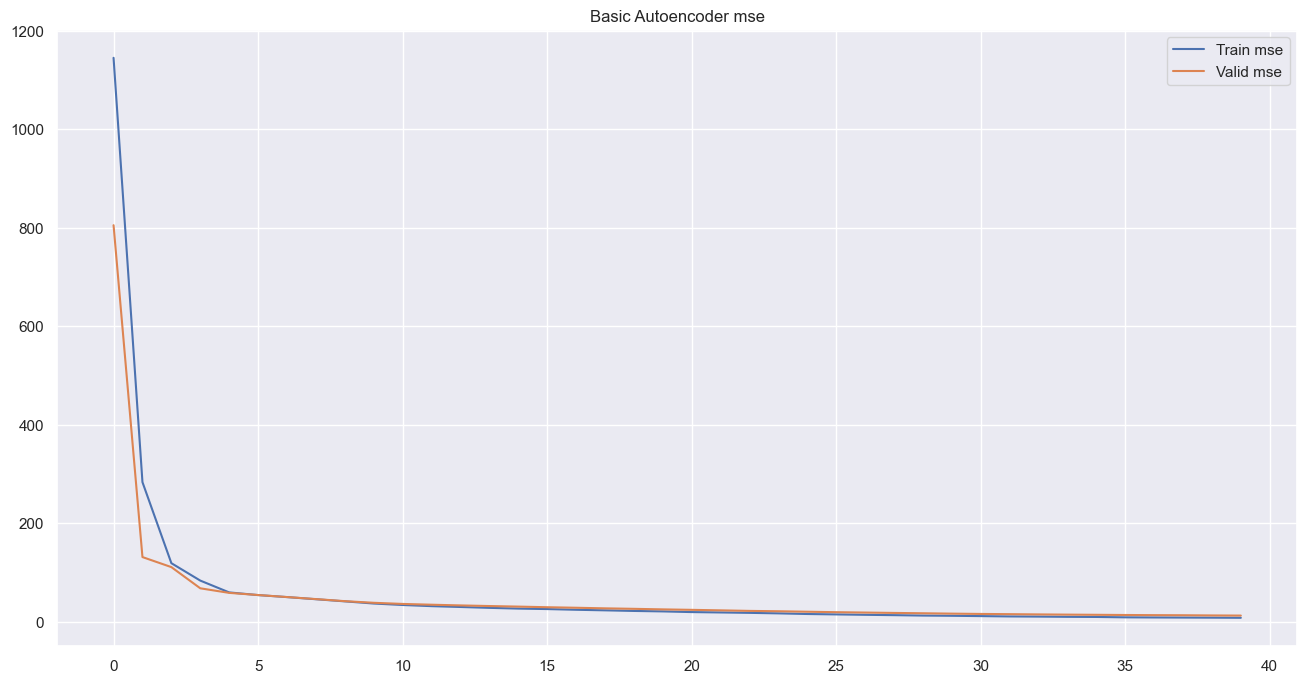

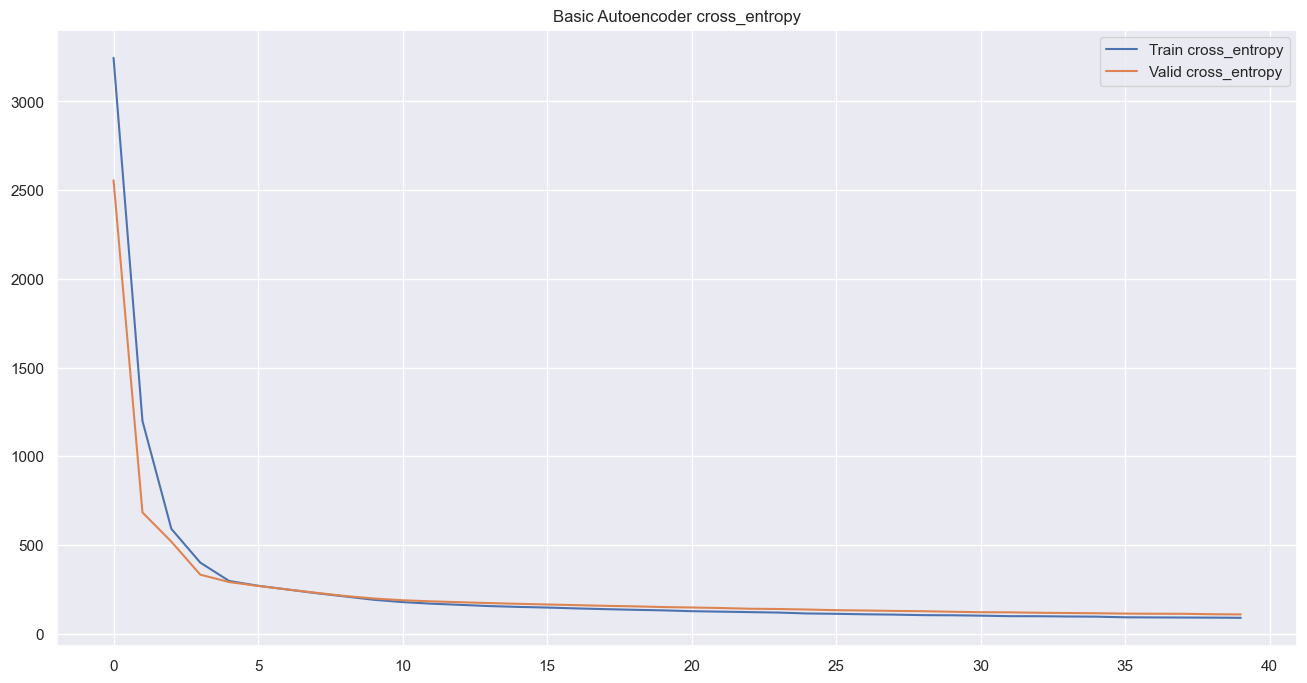

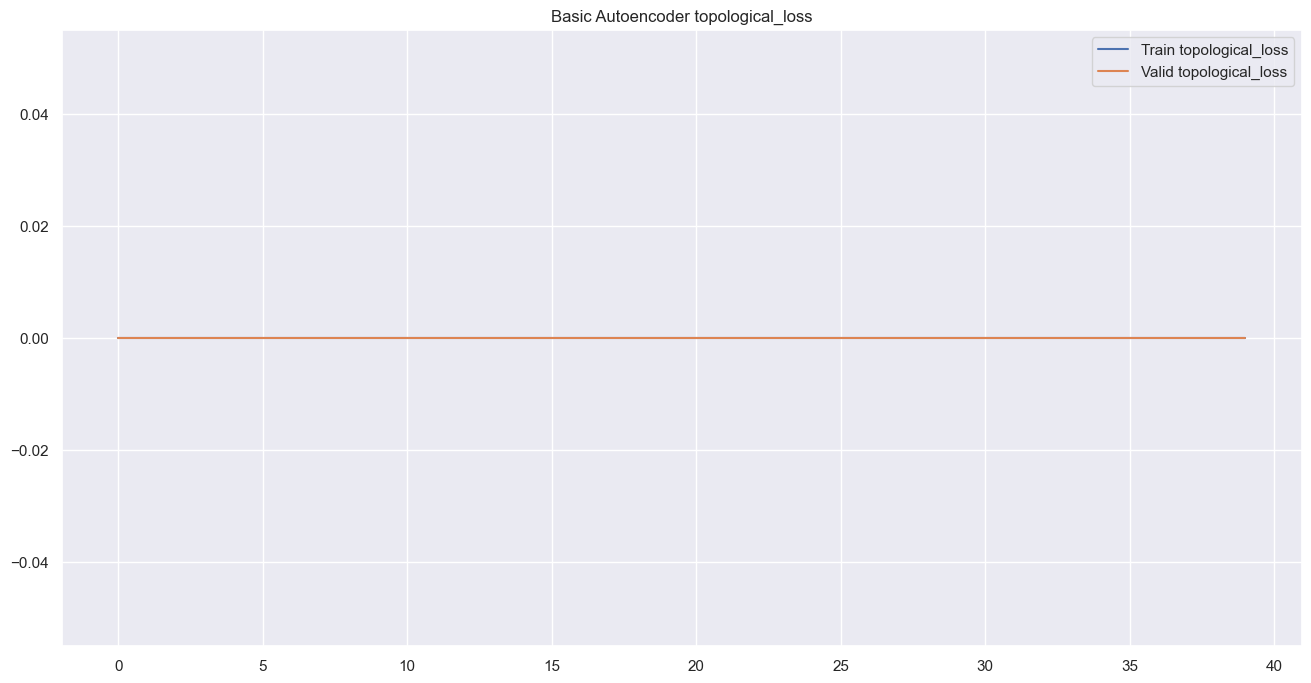

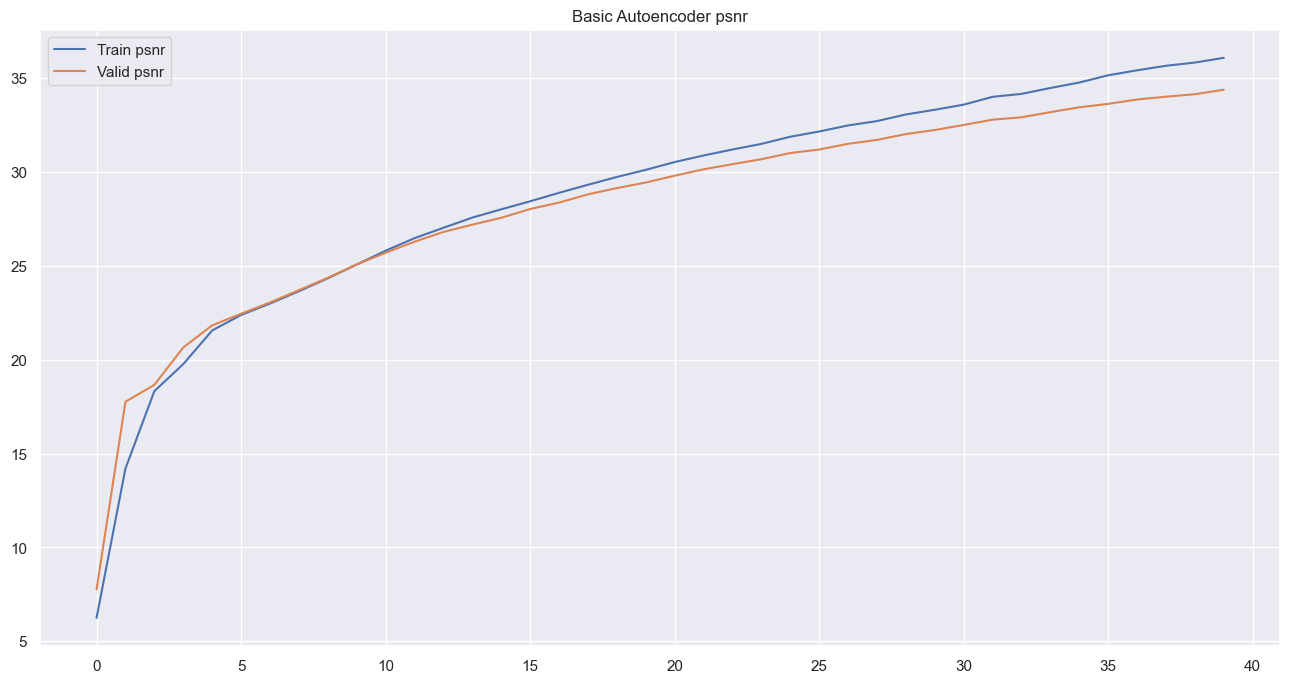

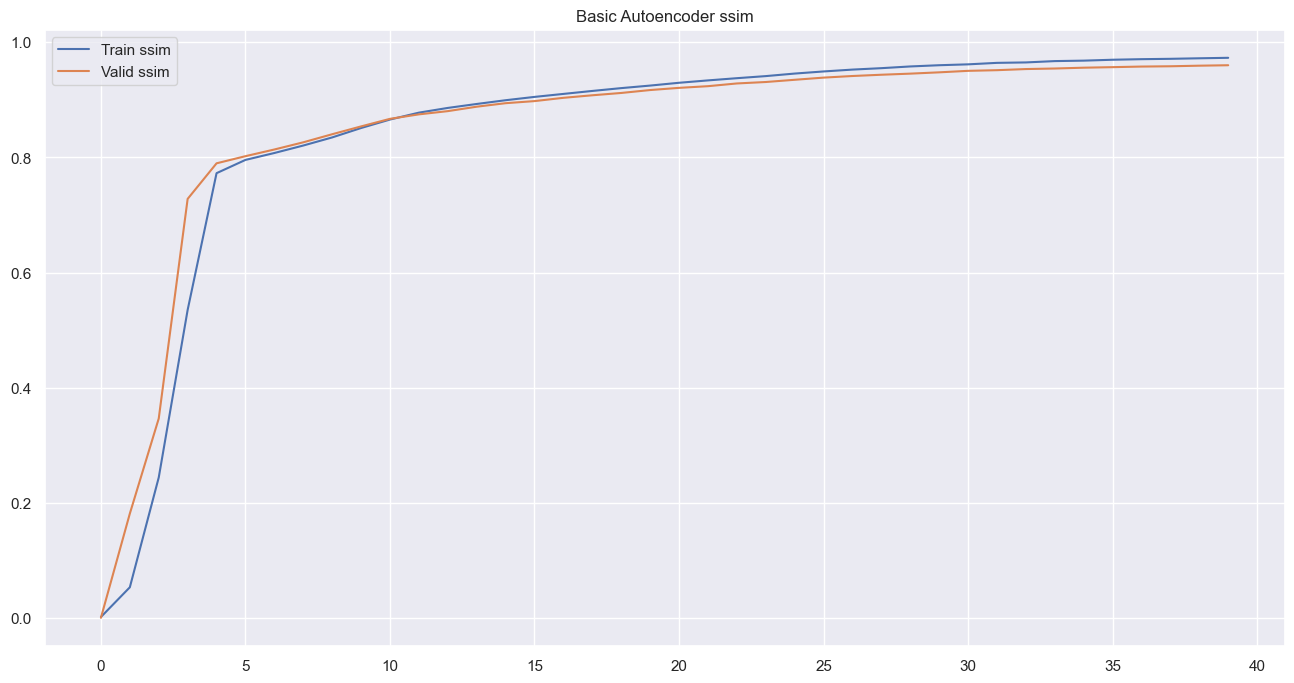

Epoch 39
 train loss: {'total': 2.8263953782935842, 'mse': 8.54537345334817, 'cross_entropy': 89.94810117025511, 'topological_loss': 0.0}, train metrics: {'psnr': 36.06903096962879, 'ssim': 0.9731968449190329}
 val loss: {'total': 109.08149466130406, 'mse': 13.064783132471744, 'cross_entropy': 109.08149466130406, 'topological_loss': 0.0}, val metrics: {'psnr': 34.371844757224714, 'ssim': 0.9602797505979854}



([{'total': 101.82245473274122,
   'mse': 1145.0418819770994,
   'cross_entropy': 3246.0396826866113,
   'topological_loss': 0.0},
  {'total': 37.609523538164616,
   'mse': 283.8122455904269,
   'cross_entropy': 1199.363638204421,
   'topological_loss': 0.0},
  {'total': 18.560226024609605,
   'mse': 119.40711881086159,
   'cross_entropy': 591.1914137709198,
   'topological_loss': 0.0},
  {'total': 12.574276033735954,
   'mse': 84.08241738414313,
   'cross_entropy': 401.0682205272512,
   'topological_loss': 0.0},
  {'total': 9.33986750146224,
   'mse': 60.075564596890274,
   'cross_entropy': 297.3753177588585,
   'topological_loss': 0.0},
  {'total': 8.49348256260298,
   'mse': 54.65161273829745,
   'cross_entropy': 270.58868603457773,
   'topological_loss': 0.0},
  {'total': 7.847354238067193,
   'mse': 50.59148038168089,
   'cross_entropy': 249.84613398692053,
   'topological_loss': 0.0},
  {'total': 7.186774109212143,
   'mse': 46.252271426232504,
   'cross_entropy': 229.03326835451

In [71]:
torch.manual_seed(0)
np.random.seed(0)

train_loader, val_loader, test_loader = get_learn_data("data/CREMI/Masks", noise_transformations=noise_transformations,
                                                       patch_mode="resize", patch_size=(40, 40), img_size=(400, 400), batch_size=32)

net = AutoEncoderRes()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)
loss_fn = nn.BCELoss(reduction="sum")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

fit(net, optimizer, 40, train_loader, val_loader, loss_fn,
    device, title="Basic Autoencoder", save_checkpoints=False, path="",
    log_wandb=False)

In [72]:
results = make_prediction(net, test_loader, device)

100%|██████████| 53/53 [00:06<00:00,  7.83it/s]


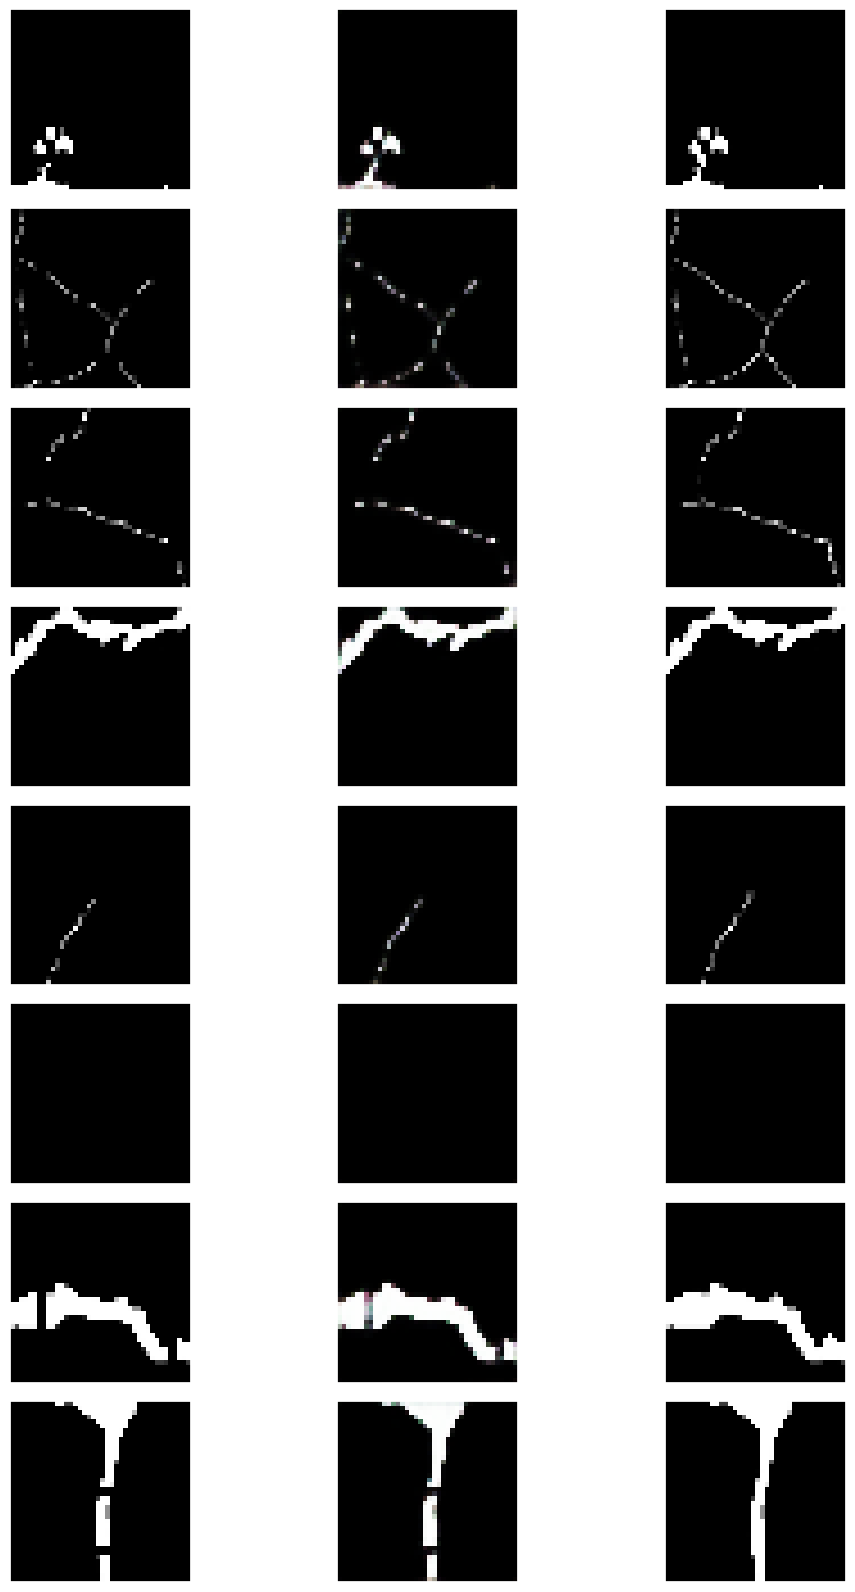

In [73]:
noised_images, gt_images, img_names, patch_nums = next(iter(test_loader))

fig = plt.figure(figsize=(10, 32))
start = 24
for idx in np.arange(start, start + 8):
    # noised input
    ax1 = fig.add_subplot(16, 3, 3 * (idx - start) + 1, xticks=[], yticks=[])
    ax1.imshow(np.squeeze(noised_images[idx]).moveaxis(0, 2))

    # model output
    ax2 = fig.add_subplot(16, 3, 3 * (idx - start) + 2, xticks=[], yticks=[])
    ax2.imshow(np.squeeze(results[img_names[idx]]).transpose(1, 2, 0))

    # gt image
    ax3 = fig.add_subplot(16, 3, 3 * (idx - start) + 3, xticks=[], yticks=[])
    ax3.imshow(np.squeeze(gt_images[idx]).moveaxis(0, 2))

    fig.tight_layout()
plt.show()

Эксперимент с комбинированным loss = topoloss + 0.01 * bceloss

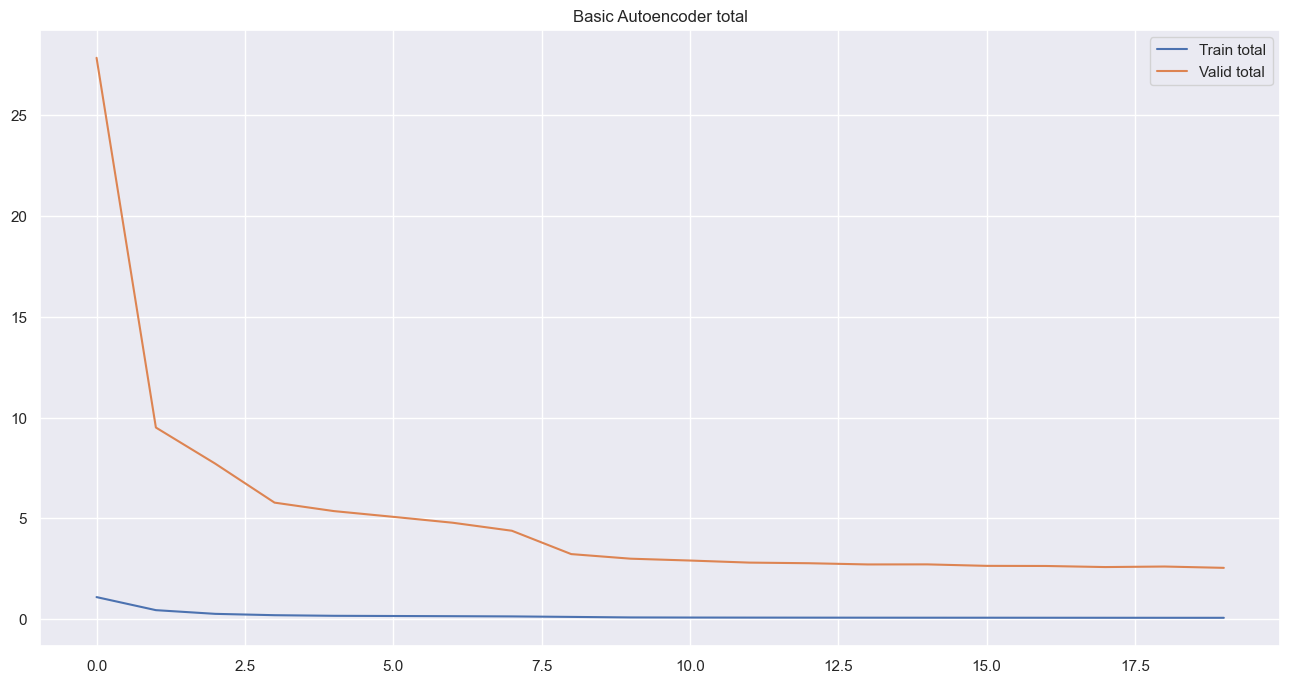

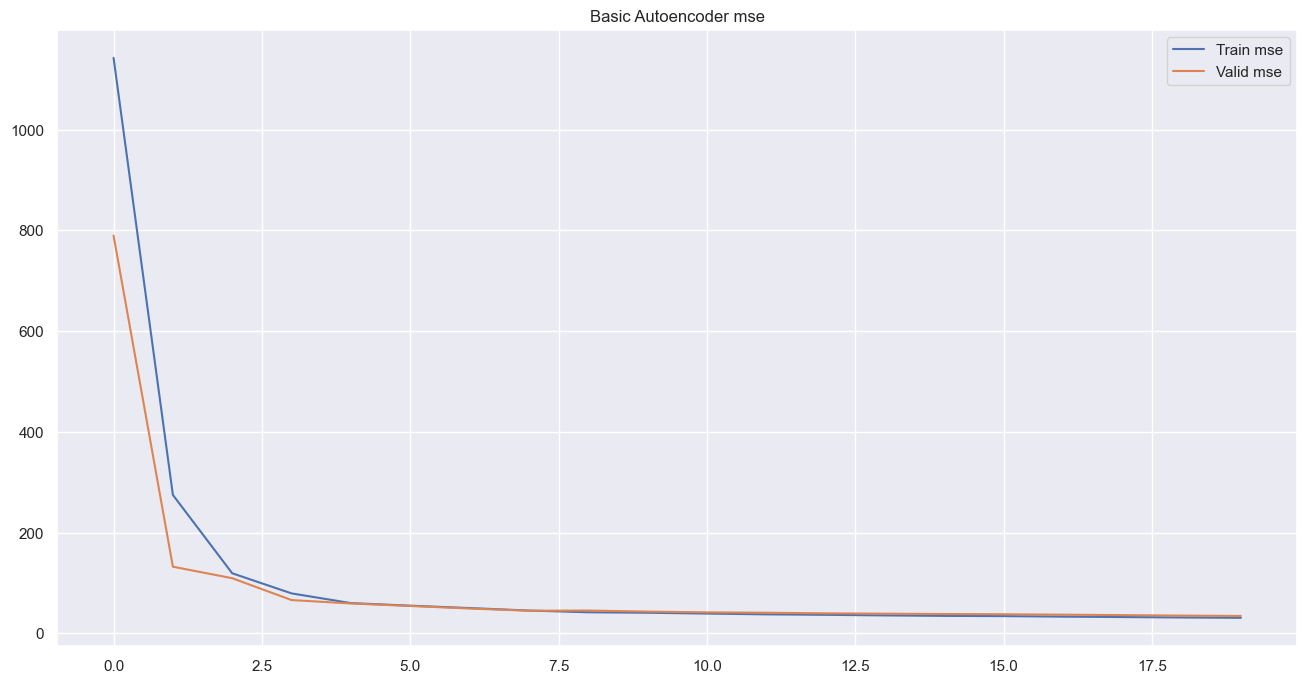

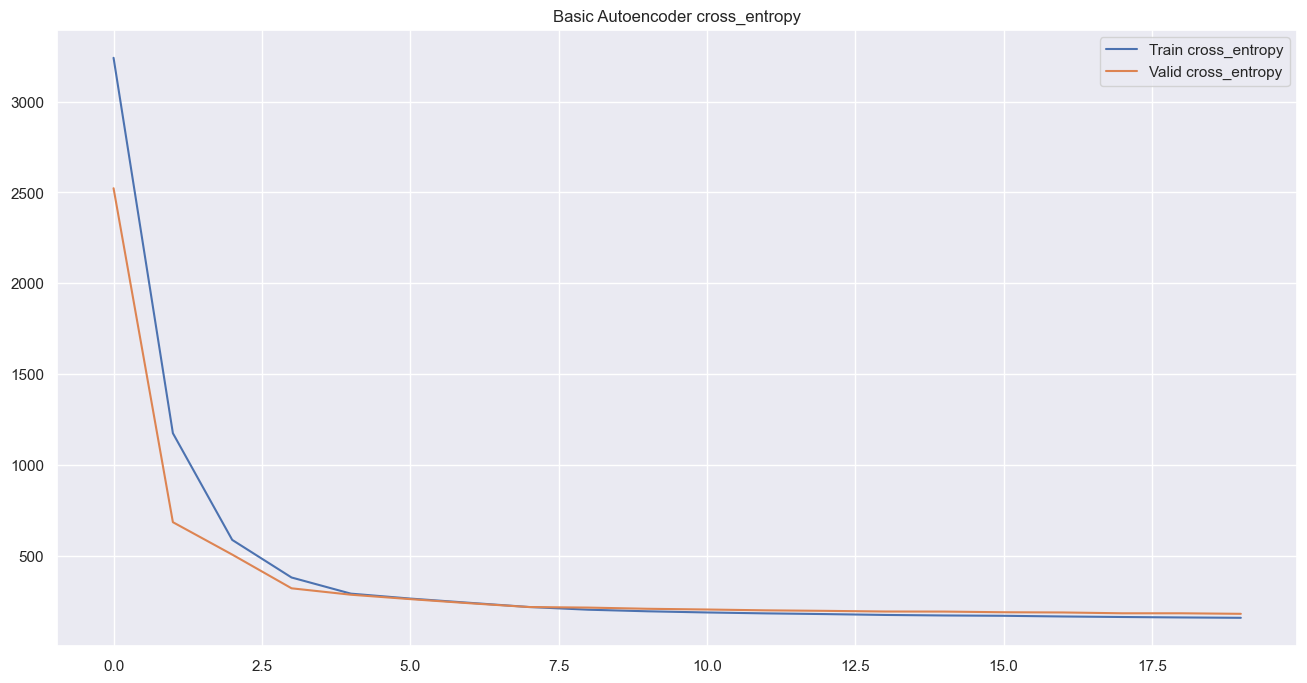

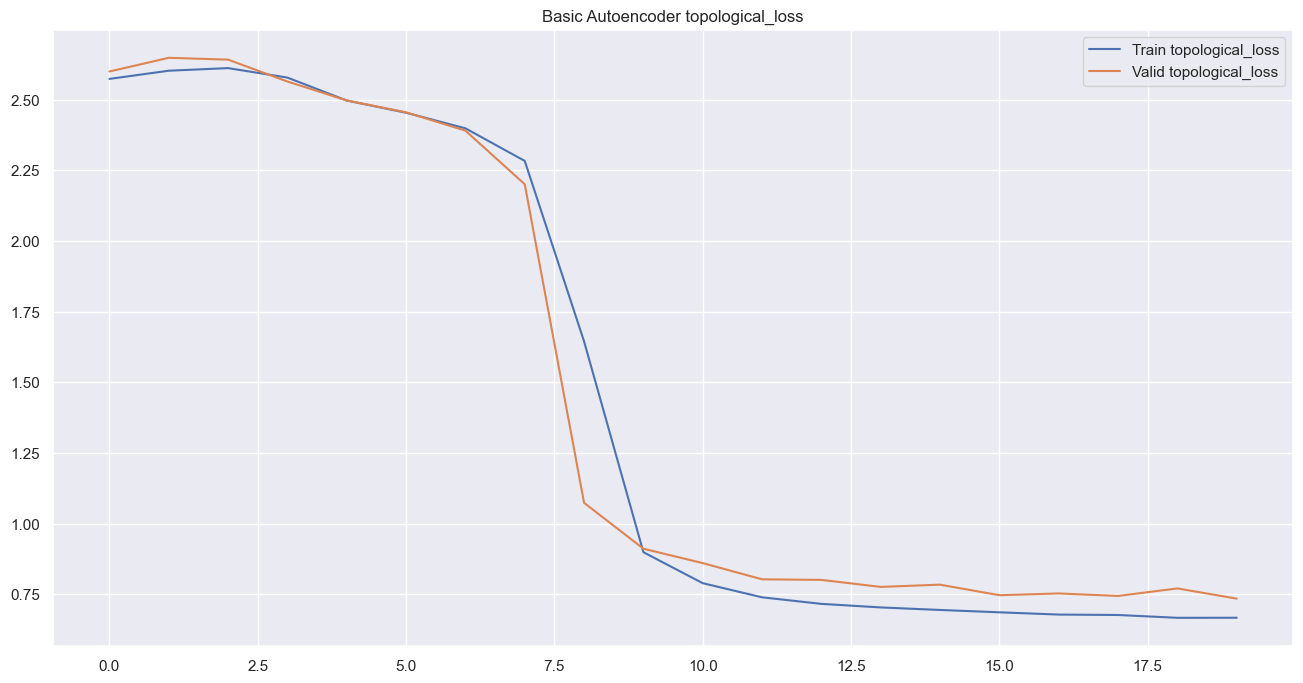

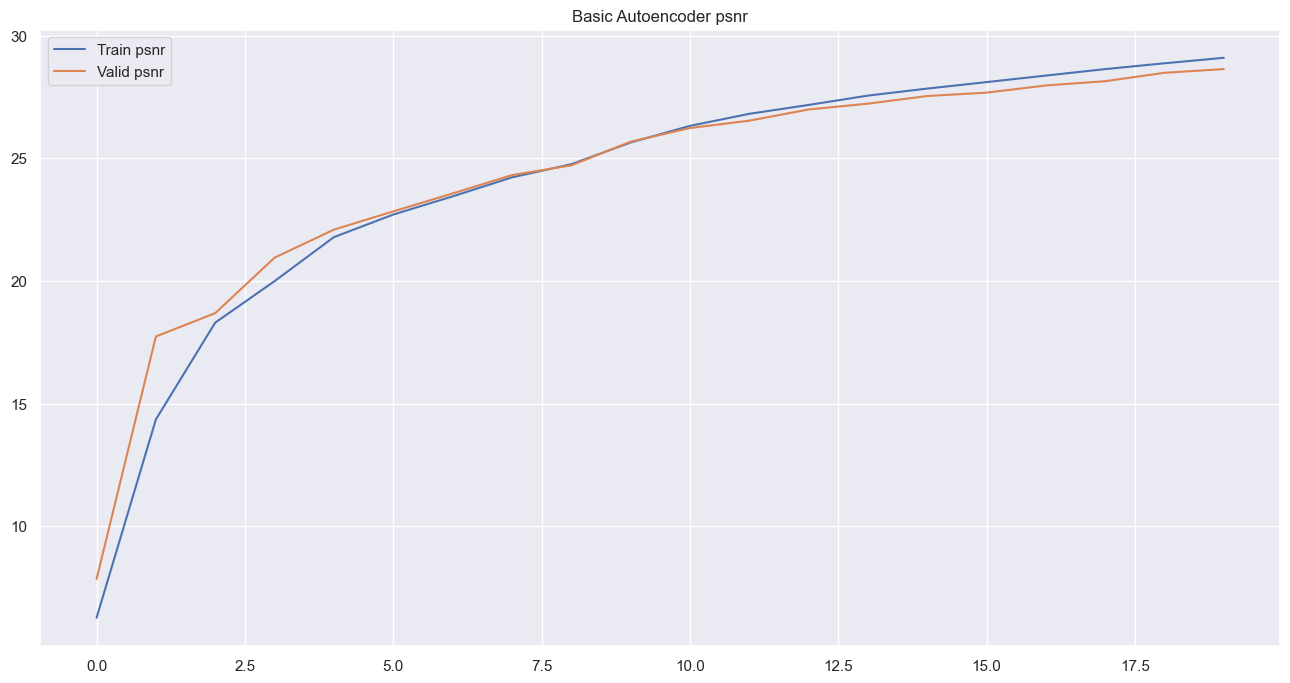

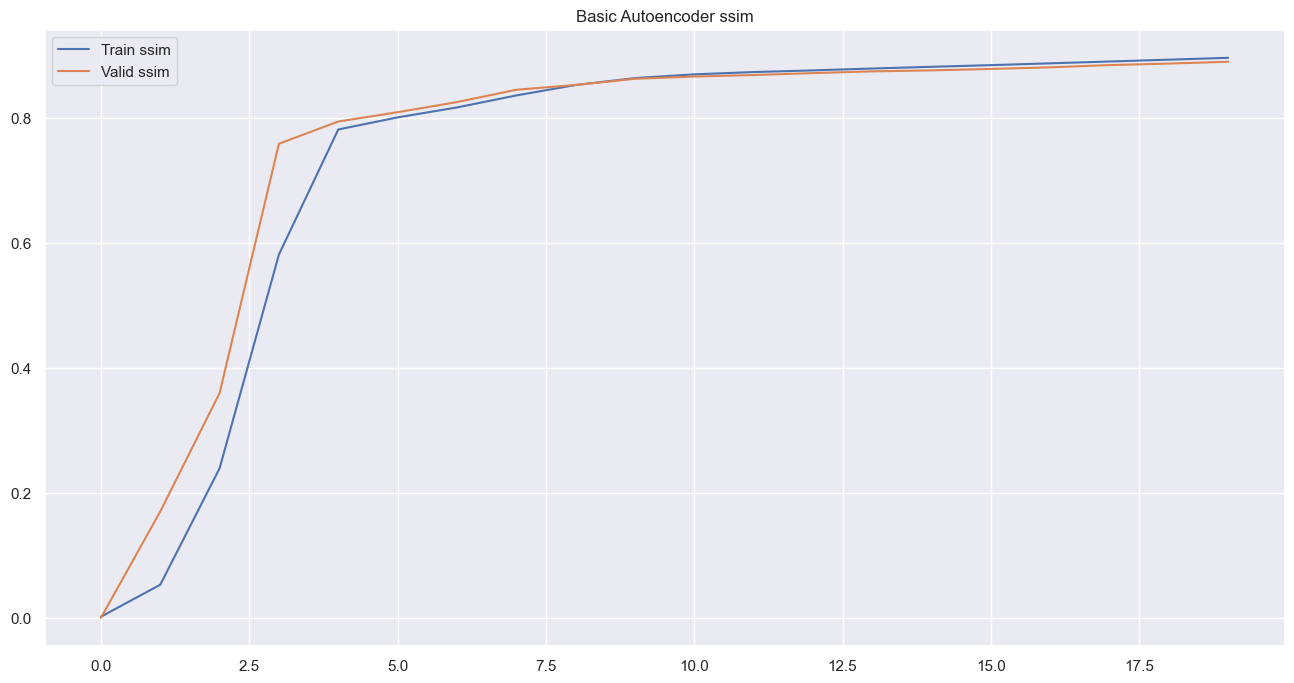

Epoch 19
 train loss: {'total': 0.0708780492086546, 'mse': 30.893142275335663, 'cross_entropy': 159.31538383881627, 'topological_loss': 0.6672934687815572}, train metrics: {'psnr': 29.099347507784152, 'ssim': 0.8959271859783697}
 val loss: {'total': 2.5472103950536646, 'mse': 34.59494119797838, 'cross_entropy': 181.22846731755405, 'topological_loss': 0.7349257548273457}, val metrics: {'psnr': 28.64017602278723, 'ssim': 0.8896249278461764}



 23%|██▎       | 24/106 [00:31<01:46,  1.30s/it]


KeyboardInterrupt: 

In [75]:
torch.manual_seed(0)
np.random.seed(0)

train_loader, val_loader, test_loader = get_learn_data("data/CREMI/Masks", noise_transformations=noise_transformations,
                                                       patch_mode="resize", patch_size=(40, 40), img_size=(400, 400), batch_size=32)

net = AutoEncoderRes()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)
loss_fn = (lambda prediction, target: nn.BCELoss(reduction="sum")(prediction, target) * 1e-2 + TopoLoss(reduction="sum")(prediction, target))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

fit(net, optimizer, 50, train_loader, val_loader, loss_fn,
    device, title="Basic Autoencoder", save_checkpoints=False, path="",
    log_wandb=False)

In [76]:
results = make_prediction(net, test_loader, device)

100%|██████████| 53/53 [00:07<00:00,  6.90it/s]


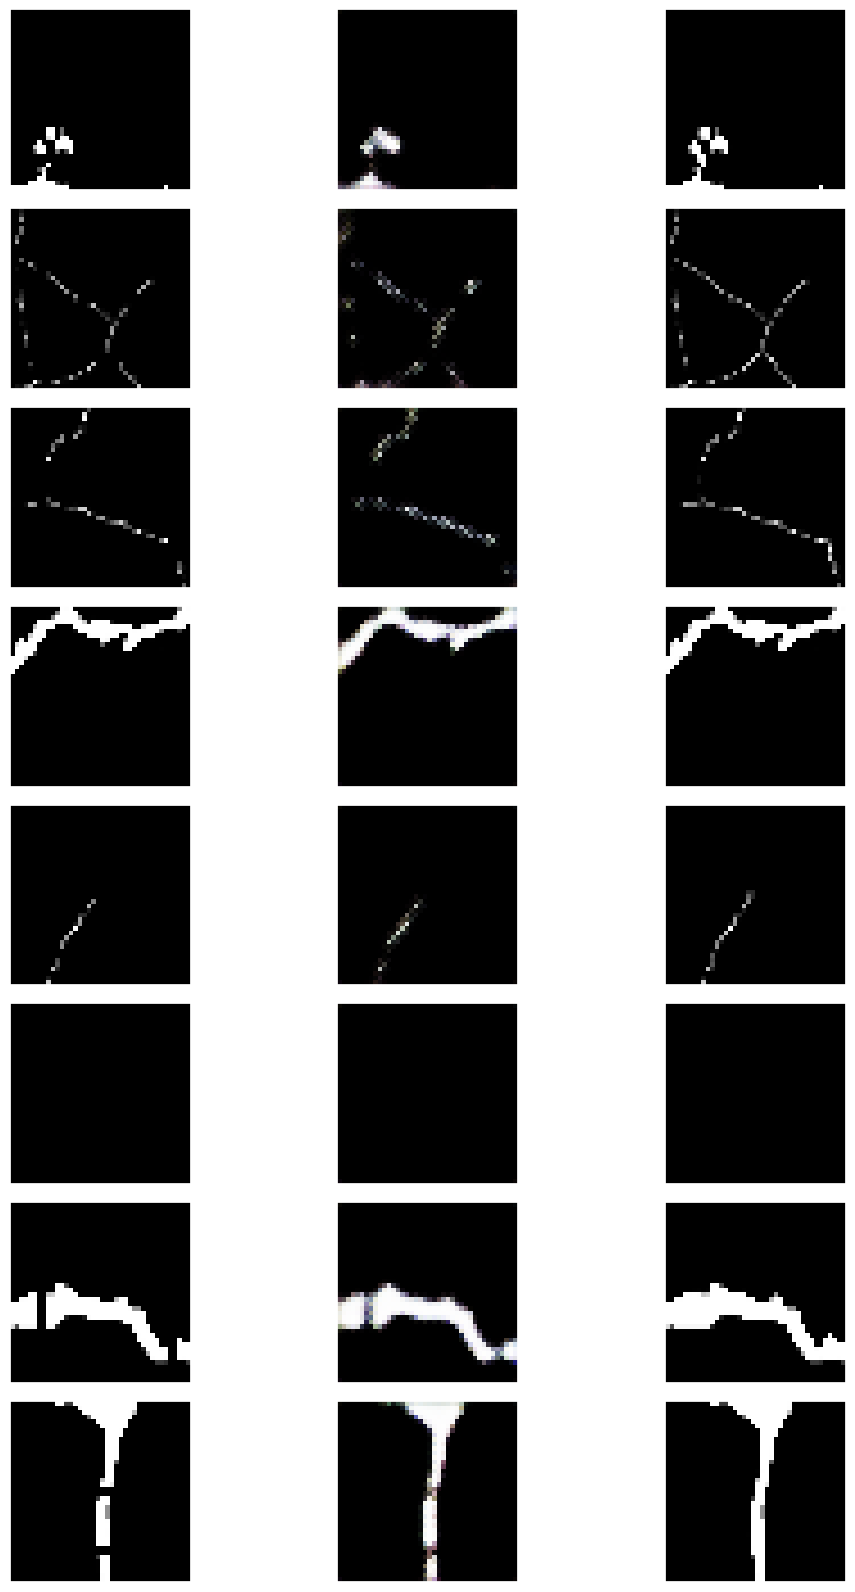

In [77]:
noised_images, gt_images, img_names, patch_nums = next(iter(test_loader))

fig = plt.figure(figsize=(10, 32))
start = 24
for idx in np.arange(start, start + 8):
    # noised input
    ax1 = fig.add_subplot(16, 3, 3 * (idx - start) + 1, xticks=[], yticks=[])
    ax1.imshow(np.squeeze(noised_images[idx]).moveaxis(0, 2))

    # model output
    ax2 = fig.add_subplot(16, 3, 3 * (idx - start) + 2, xticks=[], yticks=[])
    ax2.imshow(np.squeeze(results[img_names[idx]]).transpose(1, 2, 0))

    # gt image
    ax3 = fig.add_subplot(16, 3, 3 * (idx - start) + 3, xticks=[], yticks=[])
    ax3.imshow(np.squeeze(gt_images[idx]).moveaxis(0, 2))

    fig.tight_layout()
plt.show()